<a href="https://colab.research.google.com/github/Bingurrr/autonomous_vehicle/blob/%EC%B0%A8%EC%84%A0%EC%9D%B8%EC%8B%9D/%EC%B0%A8%EC%84%A0%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

Cloning into 'LaneNet-PyTorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 191 (delta 55), reused 154 (delta 27), pack-reused 0
Receiving objects: 100% (191/191), 29.32 MiB | 18.21 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [ ]:
import numpy as np

%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

[Errno 2] No such file or directory: 'LaneNet-PyTorch//'
/content/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils


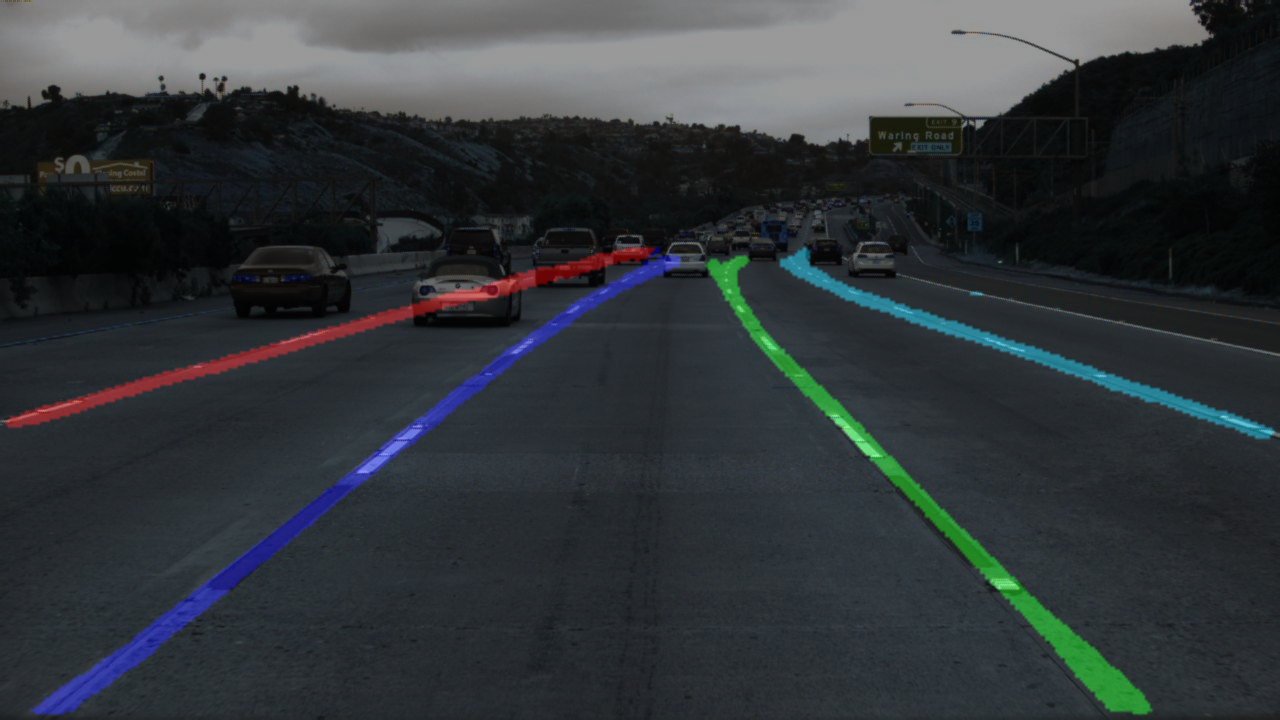

In [ ]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model' #내동영상으로 바꿔준다
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame


image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
cv2_imshow(inference(image))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Test
video_path = "/content/drive/MyDrive/lanenet/laneimg/IoT블랙박스 콘텔라 에어트론 Air10 전방카메라, 주간+심야 주행영상 _ Enuri 리뷰 - YouTube - Chrome 2021-05-02 01-14-40.mp4" # input your video path
video2segemented_video(video_path)

In [ ]:
def video2segemented_video(video_path):
    # TODO: video to frames
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    frames = []
    while (success):
      success,image = vidcap.read()
      if not success : break
    # TODO: extract lane from frame
      img = inference(image)
      frames.append(img)
    # TODO: frames to video & store video
    fps = 30
    height, width, layers = frames[0].shape
    size = (width, height)
    out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frames)) :
      out.write(frames[i])
    out.release()
    pass
